# (Optional) Colab Setup
If you aren't using Colab, you can delete the following code cell. This is just to help students with mounting to Google Drive to access the other .py files and downloading the data, which is a little trickier on Colab than on your local machine using Jupyter. 

In [3]:
# you will be prompted with a window asking to grant permissions
from google.colab import drive
drive.mount("/content/drive")

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
# fill in the path in your Google Drive in the string below. Note: do not escape slashes or spaces
import os
datadir = "/content/assignment3"
if not os.path.exists(datadir):
  !ln -s "/content/drive/My Drive/Your/Assignment3/path/" $datadir # TODO: Fill your Assignment 3 path
os.chdir(datadir)
!pwd

#Data Setup

The first thing to do is implement a dataset class to load rotated CIFAR10 images with matching labels. Since there is already a CIFAR10 dataset class implemented in `torchvision`, we will extend this class and modify the `__get_item__` method appropriately to load rotated images.

Each rotation label should be an integer in the set {0, 1, 2, 3} which correspond to rotations of 0, 90, 180, or 270 degrees respectively.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random


def rotate_img(img, rot):
    if rot == 0: # 0 degrees rotation
        return img
    # TODO: Implement rotate_img() - return the rotated img
    elif rot == 1:
        return torchvision.transforms.functional.rotate(img, 90)
    elif rot == 2:
        return torchvision.transforms.functional.rotate(img, 180)
    elif rot == 3:
        return torchvision.transforms.functional.rotate(img, 270)
    else:
        raise ValueError('rotation should be 0, 90, 180, or 270 degrees')


class CIFAR10Rotation(torchvision.datasets.CIFAR10):

    def __init__(self, root, train, download, transform) -> None:
        super().__init__(root=root, train=train, download=download, transform=transform)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index: int):
        image, cls_label = super().__getitem__(index)

        # randomly select image rotation
        rotation_label = random.choice([0, 1, 2, 3])
        image_rotated = rotate_img(image, rotation_label)

        rotation_label = torch.tensor(rotation_label).long()
        return image, image_rotated, rotation_label, torch.tensor(cls_label).long()

In [2]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

batch_size = 128

trainset = CIFAR10Rotation(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = CIFAR10Rotation(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

100%|██████████| 170498071/170498071 [00:19<00:00, 8953979.42it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### Show some example images and rotated images with labels:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


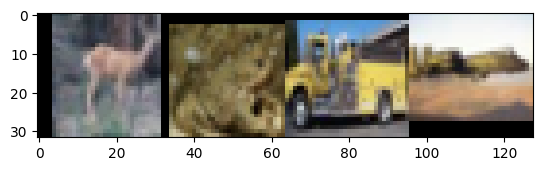

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Class labels:  deer  frog  truck plane


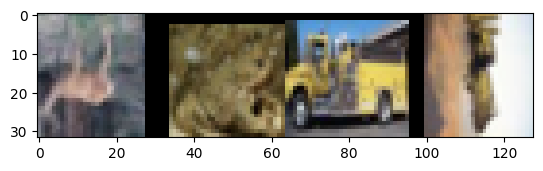

Rotation labels:  180   0     0     270  


In [3]:
import matplotlib.pyplot as plt

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

rot_classes = ('0', '90', '180', '270')


def imshow(img):
    # unnormalize
    img = transforms.Normalize((0, 0, 0), (1/0.2023, 1/0.1994, 1/0.2010))(img)
    img = transforms.Normalize((-0.4914, -0.4822, -0.4465), (1, 1, 1))(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(trainloader)
images, rot_images, rot_labels, labels = next(dataiter)

# print images and rotated images
img_grid = imshow(torchvision.utils.make_grid(images[:4], padding=0))
print('Class labels: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))
img_grid = imshow(torchvision.utils.make_grid(rot_images[:4], padding=0))
print('Rotation labels: ', ' '.join(f'{rot_classes[rot_labels[j]]:5s}' for j in range(4)))

# Evaluation code

In [4]:
import time

def run_test(net, testloader, criterion, task):
    correct = 0
    total = 0
    avg_test_loss = 0.0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for images, images_rotated, labels, cls_labels in testloader:
            if task == 'rotation':
              images, labels = images_rotated.to(device), labels.to(device)
            elif task == 'classification':
              images, labels = images.to(device), cls_labels.to(device)
            # TODO: Calculate outputs by running images through the network
            # The class with the highest energy is what we choose as prediction
            outputs = net(images)
            
            _, predicted = torch.max(outputs, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            # loss
            avg_test_loss += criterion(outputs, labels)  / len(testloader)
    print('TESTING:')
    print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f} %')
    print(f'Average loss on the 10000 test images: {avg_test_loss:.3f}')

In [5]:
def adjust_learning_rate(optimizer, epoch, init_lr, decay_epochs=30):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = init_lr * (0.1 ** (epoch // decay_epochs))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# Train a ResNet18 on the rotation task

### In this section, we will train a ResNet18 model on the rotation task. The input is a rotated image and the model predicts the rotation label. See the Data Setup section for details.

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [9]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

net = resnet18(num_classes=4)
net = net.to(device)

In [10]:
import torch.optim as optim

# TODO: Define criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08)

In [11]:
# Both the self-supervised rotation task and supervised CIFAR10 classification are
# trained with the CrossEntropyLoss, so we can use the training loop code.

def train(net, criterion, optimizer, num_epochs, decay_epochs, init_lr, task):

    for epoch in range(num_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        running_correct = 0.0
        running_total = 0.0
        start_time = time.time()

        net.train()

        for i, (imgs, imgs_rotated, rotation_label, cls_label) in enumerate(trainloader, 0):
            adjust_learning_rate(optimizer, epoch, init_lr, decay_epochs)

            # TODO: Set the data to the correct device; Different task will use different inputs and labels
            if task == 'rotation':
                inputs, labels = imgs_rotated.to(device), rotation_label.to(device)
            elif task == 'classification':
                inputs, labels = imgs.to(device), cls_label.to(device)
       

            # TODO: Zero the parameter gradients
            optimizer.zero_grad()

            # TODO: forward + backward + optimize
            #forward
            outputs = net(inputs).to(device)
            #loss
            loss = criterion(outputs, labels)
            #backward
            loss.backward()
            optimizer.step()
       
            # TODO: Get predicted results
            _, predicted = torch.max(outputs, 1)

            # print statistics
            print_freq = 100
            running_loss += loss.item()

            # calc acc
            running_total += labels.size(0)
            running_correct += (predicted == labels).sum().item()

            if i % print_freq == (print_freq - 1):    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / print_freq:.3f} acc: {100*running_correct / running_total:.2f} time: {time.time() - start_time:.2f}')
                running_loss, running_correct, running_total = 0.0, 0.0, 0.0
                start_time = time.time()

        # TODO: Run the run_test() function after each epoch; Set the model to the evaluation mode.
        net.eval()
        run_test(net, testloader, criterion, task)

    print('Finished Training')

In [14]:
train(net, criterion, optimizer, num_epochs=45, decay_epochs=15, init_lr=0.01, task='rotation')

# TODO: Save the model
PATH = './rotation.pth'
torch.save(net.state_dict(), PATH)

[1,   100] loss: 1.499 acc: 33.96 time: 7.31
[1,   200] loss: 1.220 acc: 44.62 time: 5.85
[1,   300] loss: 1.165 acc: 47.90 time: 6.05
TESTING:
Accuracy of the network on the 10000 test images: 52.57 %
Average loss on the 10000 test images: 1.114
[2,   100] loss: 1.124 acc: 51.31 time: 6.17
[2,   200] loss: 1.099 acc: 52.55 time: 5.96
[2,   300] loss: 1.083 acc: 53.66 time: 5.88
TESTING:
Accuracy of the network on the 10000 test images: 54.97 %
Average loss on the 10000 test images: 1.053
[3,   100] loss: 1.071 acc: 54.39 time: 6.02
[3,   200] loss: 1.050 acc: 55.32 time: 5.91
[3,   300] loss: 1.042 acc: 55.77 time: 5.81
TESTING:
Accuracy of the network on the 10000 test images: 56.75 %
Average loss on the 10000 test images: 1.032
[4,   100] loss: 1.037 acc: 56.09 time: 6.21
[4,   200] loss: 1.039 acc: 56.24 time: 5.86
[4,   300] loss: 1.001 acc: 57.35 time: 5.80
TESTING:
Accuracy of the network on the 10000 test images: 60.09 %
Average loss on the 10000 test images: 0.941
[5,   100] l

# Fine-tuning on the pre-trained model
### In this section, we will load the pre-trained ResNet18 model and fine-tune on the classification task. We will freeze all previous layers except for the 'layer4' block and 'fc' layer.

In [15]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

# TODO: Load the pre-trained ResNet18 model
#
PATH = './rotation.pth'
pretrained_resnet = resnet18(num_classes=10).to(device)
params = torch.load(PATH)
params['fc.weight'] = torch.randn(10, params['fc.weight'].shape[1])
params['fc.bias'] = torch.randn(10)

pretrained_resnet.load_state_dict(params)



<All keys matched successfully>

In [16]:
# TODO: Freeze all previous layers; only keep the 'layer4' block and 'fc' layer trainable
#
for param in pretrained_resnet.parameters():
	param.requires_grad = False
for param in pretrained_resnet.layer4.parameters():
	param.requires_grad = True
for param in pretrained_resnet.fc.parameters():
	param.requires_grad = True

In [17]:
# Print all the trainable parameters
params_to_update = pretrained_resnet.parameters()
print("Params to learn:")
params_to_update = []
for name,param in pretrained_resnet.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 layer4.0.conv1.weight
	 layer4.0.bn1.weight
	 layer4.0.bn1.bias
	 layer4.0.conv2.weight
	 layer4.0.bn2.weight
	 layer4.0.bn2.bias
	 layer4.0.downsample.0.weight
	 layer4.0.downsample.1.weight
	 layer4.0.downsample.1.bias
	 layer4.1.conv1.weight
	 layer4.1.bn1.weight
	 layer4.1.bn1.bias
	 layer4.1.conv2.weight
	 layer4.1.bn2.weight
	 layer4.1.bn2.bias
	 fc.weight
	 fc.bias


In [18]:
# TODO: Define criterion and optimizer
# Note that your optimizer only needs to update the parameters that are trainable.
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(pretrained_resnet.parameters(), lr=0.001)

In [19]:
train(pretrained_resnet, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')


[1,   100] loss: 2.449 acc: 25.86 time: 6.68
[1,   200] loss: 1.689 acc: 39.27 time: 5.66
[1,   300] loss: 1.589 acc: 42.52 time: 5.80
TESTING:
Accuracy of the network on the 10000 test images: 48.05 %
Average loss on the 10000 test images: 1.434
[2,   100] loss: 1.452 acc: 47.56 time: 6.43
[2,   200] loss: 1.432 acc: 48.53 time: 6.13
[2,   300] loss: 1.398 acc: 49.37 time: 5.74
TESTING:
Accuracy of the network on the 10000 test images: 51.56 %
Average loss on the 10000 test images: 1.326
[3,   100] loss: 1.355 acc: 51.30 time: 6.45
[3,   200] loss: 1.356 acc: 50.72 time: 5.95
[3,   300] loss: 1.358 acc: 50.91 time: 5.82
TESTING:
Accuracy of the network on the 10000 test images: 54.08 %
Average loss on the 10000 test images: 1.293
[4,   100] loss: 1.322 acc: 51.76 time: 6.54
[4,   200] loss: 1.318 acc: 52.55 time: 5.66
[4,   300] loss: 1.322 acc: 51.84 time: 6.00
TESTING:
Accuracy of the network on the 10000 test images: 53.68 %
Average loss on the 10000 test images: 1.258
[5,   100] l

# Fine-tuning on the randomly initialized model
### In this section, we will randomly initialize a ResNet18 model and fine-tune on the classification task. We will freeze all previous layers except for the 'layer4' block and 'fc' layer.

In [20]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

# TODO: Randomly initialize a ResNet18 model
resnet = resnet18(num_classes=10)
resnet = resnet.to(device)

In [22]:
# TODO: Freeze all previous layers; only keep the 'layer4' block and 'fc' layer trainable
# To do this, you should set requires_grad=False for the frozen layers.

for param in resnet.parameters():
    param.requires_grad = False
for param in resnet.layer4.parameters():
    param.requires_grad = True
for param in resnet.fc.parameters():
    param.requires_grad = True

In [23]:
# Print all the trainable parameters
params_to_update = resnet.parameters()
print("Params to learn:")
params_to_update = []
for name,param in resnet.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 layer4.0.conv1.weight
	 layer4.0.bn1.weight
	 layer4.0.bn1.bias
	 layer4.0.conv2.weight
	 layer4.0.bn2.weight
	 layer4.0.bn2.bias
	 layer4.0.downsample.0.weight
	 layer4.0.downsample.1.weight
	 layer4.0.downsample.1.bias
	 layer4.1.conv1.weight
	 layer4.1.bn1.weight
	 layer4.1.bn1.bias
	 layer4.1.conv2.weight
	 layer4.1.bn2.weight
	 layer4.1.bn2.bias
	 fc.weight
	 fc.bias


In [24]:
# TODO: Define criterion and optimizer
# Note that your optimizer only needs to update the parameters that are trainable.
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08)

In [25]:
train(resnet, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')

[1,   100] loss: 2.233 acc: 23.82 time: 6.77
[1,   200] loss: 1.965 acc: 29.77 time: 5.50
[1,   300] loss: 1.886 acc: 33.34 time: 5.75
TESTING:
Accuracy of the network on the 10000 test images: 36.85 %
Average loss on the 10000 test images: 1.734
[2,   100] loss: 1.815 acc: 34.44 time: 6.31
[2,   200] loss: 1.788 acc: 35.06 time: 5.99
[2,   300] loss: 1.799 acc: 35.38 time: 5.59
TESTING:
Accuracy of the network on the 10000 test images: 38.52 %
Average loss on the 10000 test images: 1.714
[3,   100] loss: 1.773 acc: 35.51 time: 6.47
[3,   200] loss: 1.756 acc: 36.66 time: 5.72
[3,   300] loss: 1.728 acc: 37.84 time: 5.93
TESTING:
Accuracy of the network on the 10000 test images: 40.28 %
Average loss on the 10000 test images: 1.654
[4,   100] loss: 1.727 acc: 38.05 time: 6.43
[4,   200] loss: 1.716 acc: 37.93 time: 5.62
[4,   300] loss: 1.730 acc: 37.29 time: 5.84
TESTING:
Accuracy of the network on the 10000 test images: 40.26 %
Average loss on the 10000 test images: 1.656
[5,   100] l

# Supervised training on the pre-trained model
### In this section, we will load the pre-trained ResNet18 model and re-train the whole model on the classification task.

In [26]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

# TODO: Load the pre-trained ResNet18 model
PATH = './rotation.pth'
pretrained_resnet = resnet18(num_classes=10).to(device)
params = torch.load(PATH)
params['fc.weight'] = torch.randn(10, params['fc.weight'].shape[1])
params['fc.bias'] = torch.randn(10)

pretrained_resnet.load_state_dict(params)

<All keys matched successfully>

In [27]:
# TODO: Define criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(pretrained_resnet.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08)

In [28]:
train(pretrained_resnet, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')

[1,   100] loss: 1.946 acc: 37.02 time: 6.92
[1,   200] loss: 1.327 acc: 52.93 time: 6.07
[1,   300] loss: 1.209 acc: 56.52 time: 5.85
TESTING:
Accuracy of the network on the 10000 test images: 62.40 %
Average loss on the 10000 test images: 1.065
[2,   100] loss: 1.052 acc: 62.48 time: 6.10
[2,   200] loss: 1.014 acc: 64.09 time: 5.69
[2,   300] loss: 1.033 acc: 63.93 time: 6.08
TESTING:
Accuracy of the network on the 10000 test images: 66.20 %
Average loss on the 10000 test images: 0.972
[3,   100] loss: 1.169 acc: 60.99 time: 6.02
[3,   200] loss: 1.066 acc: 63.18 time: 5.86
[3,   300] loss: 0.933 acc: 66.93 time: 5.85
TESTING:
Accuracy of the network on the 10000 test images: 70.72 %
Average loss on the 10000 test images: 0.841
[4,   100] loss: 0.991 acc: 65.46 time: 6.12
[4,   200] loss: 0.898 acc: 68.32 time: 5.92
[4,   300] loss: 0.843 acc: 70.50 time: 5.87
TESTING:
Accuracy of the network on the 10000 test images: 73.22 %
Average loss on the 10000 test images: 0.784
[5,   100] l

# Supervised training on the randomly initialized model
### In this section, we will randomly initialize a ResNet18 model and re-train the whole model on the classification task.

In [29]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

# TODO: Randomly initialize a ResNet18 model

random_resnet = resnet18(num_classes = 10).to(device)


In [30]:
# TODO: Define criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(random_resnet.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08)

In [31]:
train(random_resnet, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')

[1,   100] loss: 2.281 acc: 22.59 time: 6.02
[1,   200] loss: 1.887 acc: 31.14 time: 5.93
[1,   300] loss: 1.728 acc: 36.69 time: 6.18
TESTING:
Accuracy of the network on the 10000 test images: 41.81 %
Average loss on the 10000 test images: 1.617
[2,   100] loss: 1.520 acc: 43.95 time: 6.10
[2,   200] loss: 1.469 acc: 46.70 time: 5.92
[2,   300] loss: 1.411 acc: 48.60 time: 5.85
TESTING:
Accuracy of the network on the 10000 test images: 53.51 %
Average loss on the 10000 test images: 1.291
[3,   100] loss: 1.273 acc: 54.19 time: 6.13
[3,   200] loss: 1.225 acc: 56.02 time: 6.09
[3,   300] loss: 1.185 acc: 57.15 time: 5.90
TESTING:
Accuracy of the network on the 10000 test images: 59.67 %
Average loss on the 10000 test images: 1.180
[4,   100] loss: 1.094 acc: 60.99 time: 6.16
[4,   200] loss: 1.046 acc: 62.51 time: 5.91
[4,   300] loss: 1.048 acc: 62.58 time: 5.87
TESTING:
Accuracy of the network on the 10000 test images: 63.87 %
Average loss on the 10000 test images: 1.063
[5,   100] l

# Extra Credit: Using DenseNet to train rotation prediction task

In [17]:
import torch.nn as nn
import torch.nn.functional as F
from functools import partial
from torchvision.models import DenseNet
import math


net = DenseNet(num_classes=4)
net = net.to(device)

import torch.optim as optim

# TODO: Define criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08)

def train(net, criterion, optimizer, num_epochs, decay_epochs, init_lr, task):

    for epoch in range(num_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        running_correct = 0.0
        running_total = 0.0
        start_time = time.time()

        net.train()

        for i, (imgs, imgs_rotated, rotation_label, cls_label) in enumerate(trainloader, 0):
            adjust_learning_rate(optimizer, epoch, init_lr, decay_epochs)

            # TODO: Set the data to the correct device; Different task will use different inputs and labels
            if task == 'rotation':
                inputs, labels = imgs_rotated.to(device), rotation_label.to(device)
            elif task == 'classification':
                inputs, labels = imgs.to(device), cls_label.to(device)
       

            # TODO: Zero the parameter gradients
            optimizer.zero_grad()

            # TODO: forward + backward + optimize
            #forward
            outputs = net(inputs).to(device)
            #loss
            loss = criterion(outputs, labels)
            #backward
            loss.backward()
            optimizer.step()
       
            # TODO: Get predicted results
            _, predicted = torch.max(outputs, 1)

            # print statistics
            print_freq = 100
            running_loss += loss.item()

            # calc acc
            running_total += labels.size(0)
            running_correct += (predicted == labels).sum().item()

            if i % print_freq == (print_freq - 1):    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / print_freq:.3f} acc: {100*running_correct / running_total:.2f} time: {time.time() - start_time:.2f}')
                running_loss, running_correct, running_total = 0.0, 0.0, 0.0
                start_time = time.time()

        # TODO: Run the run_test() function after each epoch; Set the model to the evaluation mode.
        net.eval()
        run_test(net, testloader, criterion, task)

    print('Finished Training')
    
train(net, criterion, optimizer, num_epochs=45, decay_epochs=15, init_lr=0.01, task='rotation')

# TODO: Save the model
PATH = './rotation.pth'
torch.save(net.state_dict(), PATH)

[1,   100] loss: 1.542 acc: 31.46 time: 7.28
[1,   200] loss: 1.371 acc: 39.32 time: 6.92
[1,   300] loss: 1.323 acc: 38.51 time: 7.12
TESTING:
Accuracy of the network on the 10000 test images: 46.36 %
Average loss on the 10000 test images: 1.184
[2,   100] loss: 1.182 acc: 46.31 time: 7.49
[2,   200] loss: 1.150 acc: 48.46 time: 7.21
[2,   300] loss: 1.122 acc: 50.28 time: 7.22
TESTING:
Accuracy of the network on the 10000 test images: 54.27 %
Average loss on the 10000 test images: 1.056
[3,   100] loss: 1.091 acc: 52.20 time: 7.30
[3,   200] loss: 1.065 acc: 53.88 time: 7.04
[3,   300] loss: 1.045 acc: 54.95 time: 7.06
TESTING:
Accuracy of the network on the 10000 test images: 56.06 %
Average loss on the 10000 test images: 1.023
[4,   100] loss: 1.020 acc: 56.08 time: 7.34
[4,   200] loss: 1.000 acc: 57.35 time: 7.20
[4,   300] loss: 0.992 acc: 57.57 time: 7.19
TESTING:
Accuracy of the network on the 10000 test images: 59.56 %
Average loss on the 10000 test images: 0.951
[5,   100] l

## DenseNet for supervised classification

In [27]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import DenseNet

# TODO: Load the pre-trained ResNet18 model
PATH = './rotation.pth'
net = DenseNet(num_classes=10).to(device)
params = torch.load(PATH)
params['classifier.weight'] = torch.randn(10, params['classifier.weight'].shape[1])
params['classifier.bias'] = torch.randn(10)

net.load_state_dict(params)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08)
train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')

[1,   100] loss: 1.685 acc: 41.16 time: 7.46
[1,   200] loss: 1.259 acc: 54.74 time: 7.29
[1,   300] loss: 1.099 acc: 61.22 time: 7.23
TESTING:
Accuracy of the network on the 10000 test images: 64.53 %
Average loss on the 10000 test images: 1.000
[2,   100] loss: 0.956 acc: 65.77 time: 7.00
[2,   200] loss: 0.927 acc: 67.16 time: 7.02
[2,   300] loss: 0.903 acc: 68.45 time: 7.16
TESTING:
Accuracy of the network on the 10000 test images: 69.39 %
Average loss on the 10000 test images: 0.885
[3,   100] loss: 0.821 acc: 71.26 time: 7.26
[3,   200] loss: 0.808 acc: 71.58 time: 7.30
[3,   300] loss: 0.808 acc: 71.74 time: 7.52
TESTING:
Accuracy of the network on the 10000 test images: 71.59 %
Average loss on the 10000 test images: 0.811
[4,   100] loss: 0.747 acc: 73.59 time: 7.61
[4,   200] loss: 0.725 acc: 74.35 time: 7.01
[4,   300] loss: 0.712 acc: 75.23 time: 6.95
TESTING:
Accuracy of the network on the 10000 test images: 74.71 %
Average loss on the 10000 test images: 0.730
[5,   100] l